In [1]:
import pycaret
import pandas as pd
import numpy as np
import sklearn

In [3]:
from pycaret.classification import *

# Classificação

In [7]:
class_test = pd.read_csv('Data/classification_data/classification_test.csv')
class_train = pd.read_csv('Data/classification_data/classification_train.csv')

Para encontrar o  melhor modelo para cada caso, utilizarei o framework Pycaret como input inicial. Esse framework automatiza o pipeline de ML, abstraindo em alto nível.

Utilizarei como critério de avaliação dos modelos o AUC, F1 Score, Precision e Recall

In [8]:
s = setup(class_train, target = 'target', session_id = 123, log_experiment = True, experiment_name = 'classification', test_data=class_test, index=False)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 3)"
4,Transformed data shape,"(1000, 3)"
5,Transformed train set shape,"(670, 3)"
6,Transformed test set shape,"(330, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [15]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8836,0.9369,0.9057,0.8702,0.8865,0.7671,0.7697,0.0690
knn,K Neighbors Classifier,0.8776,0.9268,0.8851,0.8762,0.8794,0.7553,0.7574,3.6510
ada,Ada Boost Classifier,0.8701,0.9363,0.8969,0.8539,0.8746,0.7401,0.7417,0.0600
et,Extra Trees Classifier,0.8687,0.9325,0.8703,0.8722,0.8700,0.7374,0.7396,0.5910
rf,Random Forest Classifier,0.8657,0.9307,0.8703,0.8661,0.8670,0.7314,0.7334,0.1950
lightgbm,Light Gradient Boosting Machine,0.8642,0.9310,0.8644,0.8704,0.8654,0.7286,0.7320,0.0710
nb,Naive Bayes,0.8373,0.9201,0.8349,0.8421,0.8381,0.6746,0.6752,0.0230
qda,Quadratic Discriminant Analysis,0.8373,0.9198,0.8349,0.8421,0.8381,0.6746,0.6752,0.0290
lr,Logistic Regression,0.8358,0.9207,0.8349,0.8404,0.8369,0.6717,0.6728,1.2050
ridge,Ridge Classifier,0.8358,0.0000,0.8320,0.8417,0.8364,0.6717,0.6724,0.0160


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

Melhor score foi relativo ao modelo Gradient Boosting Classifier. Ele teve o melhor F1 score, ou seja, melhor desempenho considerando a média harmônica da precisão e recall

In [18]:
classifier = create_model('gbc', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8788,0.9365,0.8820,0.8712,0.8765,0.7575,0.7576


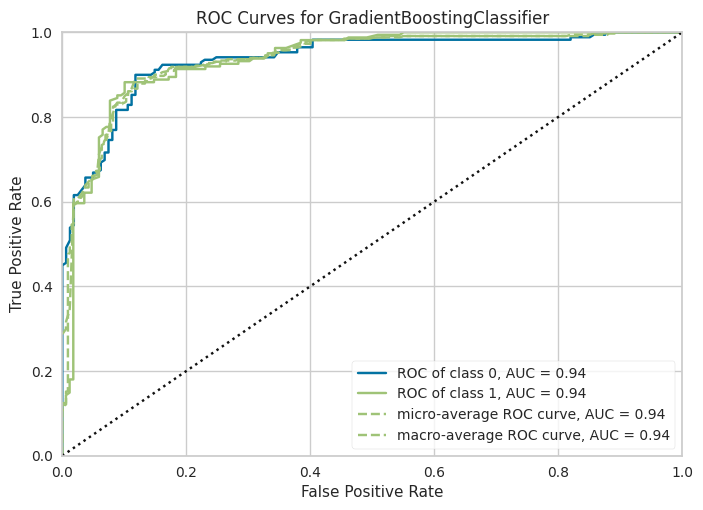

In [20]:
plot_model(classifier, plot = 'auc')

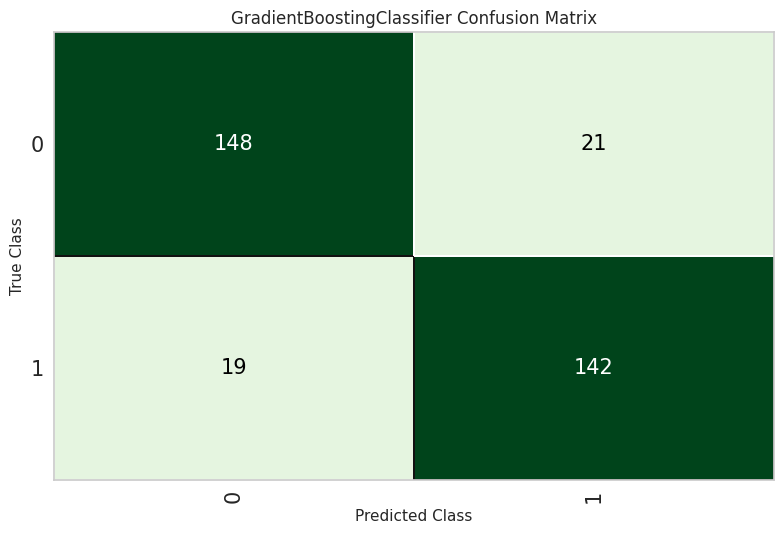

In [21]:
plot_model(classifier, plot = 'confusion_matrix')

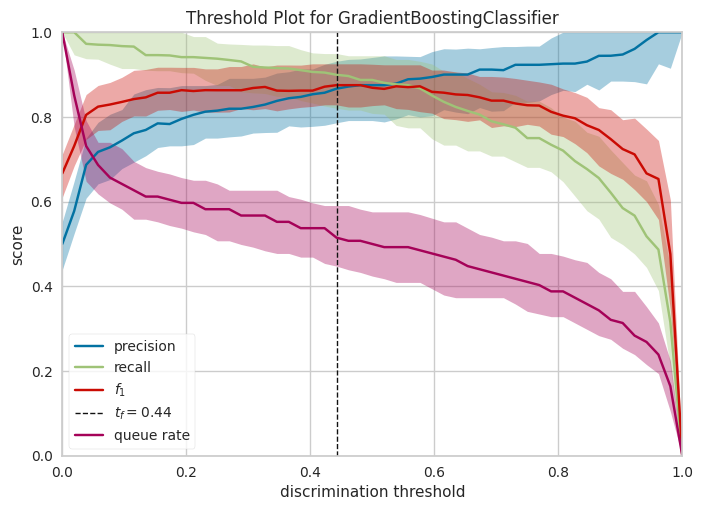

In [22]:
plot_model(classifier, plot = 'threshold')

Threshold de discriminação entre as classes que maximiza o F1 score é 0.44

In [28]:
# Salvando modelo
save_model(classifier, 'Models/gbc_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['x1', 'x2'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='l

In [4]:
classifier = load_model('Models/gbc_model')

Transformation Pipeline and Model Successfully Loaded


### Analisando importância das features

O PyCaret utiliza o algoritmo Random Forest para calcular a importância das features. 

A importância é calculada com base em duas métricas: Gini Importance e Mean Decrease Impurity (MDI).

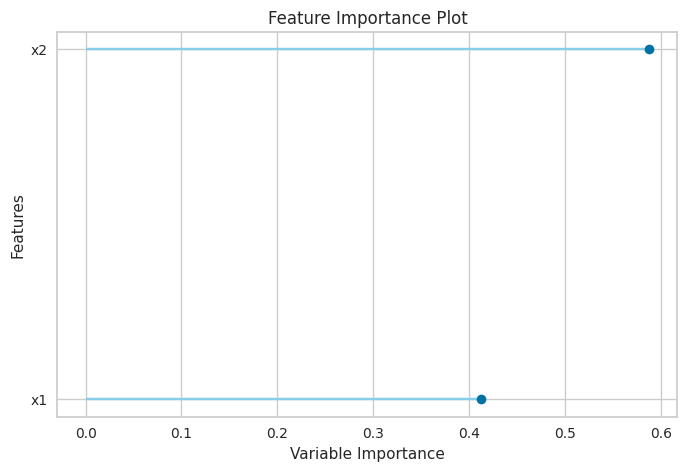

In [9]:
plot_model(classifier, plot = 'feature')

A variável x2 tem maior importância na determinação da classe de acordo com os critérios de Gini importance e MDI

# Regressão

In [11]:
reg_train = pd.read_csv('Data/regression_data/regression_train.csv')
reg_test = pd.read_csv('Data/regression_data/regression_test.csv')

In [39]:
from pycaret.regression import *
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer

In [22]:
reg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  715 non-null    float64
 1   X1      1042 non-null   float64
 2   X2      1031 non-null   float64
 3   X3      1042 non-null   float64
 4   X4      1042 non-null   float64
 5   X5      1042 non-null   float64
 6   X6      1042 non-null   int64  
 7   X7      1042 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 65.2 KB


In [21]:
reg_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  180 non-null    float64
 1   X1      261 non-null    float64
 2   X2      261 non-null    float64
 3   X3      261 non-null    float64
 4   X4      261 non-null    float64
 5   X5      261 non-null    float64
 6   X6      261 non-null    int64  
 7   X7      261 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 16.4 KB


In [27]:
reg_train

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680
...,...,...,...,...,...,...,...,...
1037,4296.426459,5.375810,6.937947,55.810467,1.698025,-65.819509,8,16.304176
1038,54.530919,0.619207,-1.925819,48.168606,1.357223,-65.385243,8,-4.525675
1039,1636.535078,4.548172,2.886253,47.775525,1.278439,-56.312543,8,6.782694
1040,NaN,1.806045,-3.015213,48.352707,4.627906,-57.722688,5,-7.085751


In [30]:
reg_train.dropna(subset='target', inplace=True)
reg_test.dropna(subset='target', inplace=True)

Muitos valores nulos na variável target. Irei removê-los e imputar valores baseados nos valores próximos (knn) nas features.

In [31]:
s = setup(reg_train, target = 'target', session_id = 123, log_experiment = False, experiment_name = 'regression', test_data=reg_test, index=False, numeric_imputation='knn')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(895, 8)"
4,Transformed data shape,"(895, 8)"
5,Transformed train set shape,"(715, 8)"
6,Transformed test set shape,"(180, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


2023/07/02 18:30:59 INFO mlflow.tracking.fluent: Experiment with name 'regression' does not exist. Creating a new experiment.


Criando métrica de correlação entre y_pred e y_observado

In [36]:
# Função para calcular a correlação
def correlation_metric(y_true, y_pred):
    corr, _ = pearsonr(y_true, y_pred)
    return corr


In [32]:
best_reg = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,74.3133,20724.6584,134.7313,0.9922,0.3791,1.2869,0.0460
et,Extra Trees Regressor,89.4913,30065.1912,165.2742,0.9887,0.3561,0.9648,0.1790
rf,Random Forest Regressor,103.4761,38229.9481,185.0203,0.9856,0.4119,1.5293,0.1290
lightgbm,Light Gradient Boosting Machine,97.1748,69991.4174,237.4619,0.9753,0.3692,1.1357,0.0520
dt,Decision Tree Regressor,160.3798,69152.1518,259.5059,0.9723,0.4723,0.8438,0.0120
knn,K Neighbors Regressor,168.9647,89969.5969,291.6842,0.9654,0.6567,3.3104,0.0160
ada,AdaBoost Regressor,259.1187,112444.7765,332.3563,0.9541,1.2143,19.3259,0.0560
en,Elastic Net,343.1219,217526.5031,461.2551,0.9135,1.3692,36.0732,0.0120
llar,Lasso Least Angle Regression,346.7476,217297.5516,461.3348,0.9134,1.3680,36.6081,0.0170
br,Bayesian Ridge,346.4590,217302.6922,461.3128,0.9134,1.3666,36.5788,0.0140


Melhor modelo de acordo com critérios de Mean Squared Error, Root mean squared error e R2 é o Gradient Boosting Regressor.

In [45]:
scorer = make_scorer(correlation_metric, greater_is_better=True)
add_metric(id="corr", name="Correlation", score_func=correlation_metric)


Name                                                     Correlation
Display Name                                             Correlation
Score Function       <function correlation_metric at 0x7f764c0ca3b0>
Scorer                               make_scorer(correlation_metric)
Target                                                          pred
Args                                                              {}
Greater is Better                                               True
Custom                                                          True
Name: corr, dtype: object

In [49]:
# tunando modelo para maximizar a correlação entre os valores reais e preditos
tuned_reg = tune_model(best_reg, custom_scorer="corr")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:50:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE,Correlation
Fold,,,,,,,
0,57.3310,7563.8278,86.9703,0.9966,0.4676,4.2835,0.9983
1,62.0050,8969.3169,94.7065,0.9955,0.3349,0.4016,0.9980
2,96.3434,32246.1080,179.5720,0.9904,0.2921,0.2152,0.9962
3,59.7910,11587.8881,107.6471,0.9955,0.2115,0.1478,0.9983
4,84.4722,33806.7440,183.8661,0.9890,0.1655,0.1410,0.9953
5,56.6260,9614.7116,98.0546,0.9930,0.4688,0.8105,0.9967
6,113.9360,35468.9761,188.3321,0.9865,0.1910,0.1431,0.9933
7,65.7625,10199.5353,100.9927,0.9951,0.2640,0.1903,0.9976
8,83.3933,35845.8008,189.3299,0.9886,0.5293,1.4351,0.9956


Fitting 10 folds for each of 10 candidates, totalling 100 fits


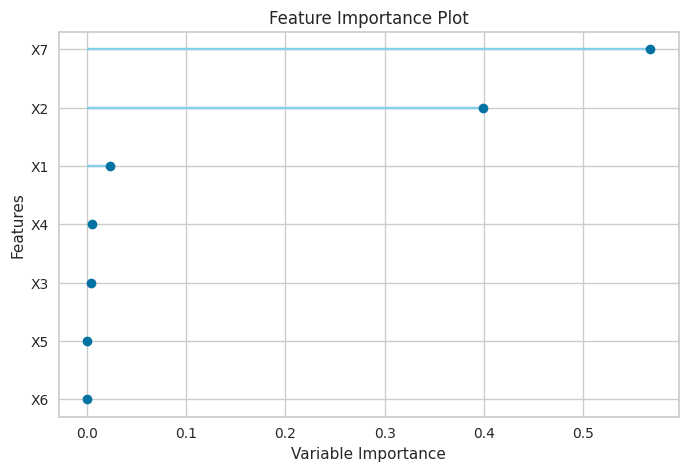

In [50]:
# Plot da importância das variáveis
plot_model(tuned_reg, plot='feature')

As features X7 e X2 são as mais relevantes para o modelo de regressão. No contexto do Gradiente Boosting Regressor, a forma de cálculo da feature importance é baseado na redução da média da função de perda (RMSE) advinda da adição da feature no regressor. As features que resultam em maior redução da função de perda tem maior importância na predição.

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [ ]:
# Treinamento do modelo com todos os dados de treinamento
final_model = finalize_model(tuned_reg)

In [57]:
final_model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                                             'X7'],
                                    transformer=KNNImputer(add_indicator=False,
                                                           copy=True,
                                                           keep_empty_features=False,
                                                           metric='nan_euclidean',
                                                           missing_values=nan,
                                                           n_neighbors=5,
                                                           weights='uniform'))),
                ('categorical_imputer',
                 TransformerWrappe...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.15,
                                           loss='squared_error', max_depth=7,
                                           max_features=1.0,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.02,
                                           min_samples_leaf=5,
                                           min_samples_split=5,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=230,
                                           n_iter_no_change=None,
                                           random_state=123, subsample=0.85,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

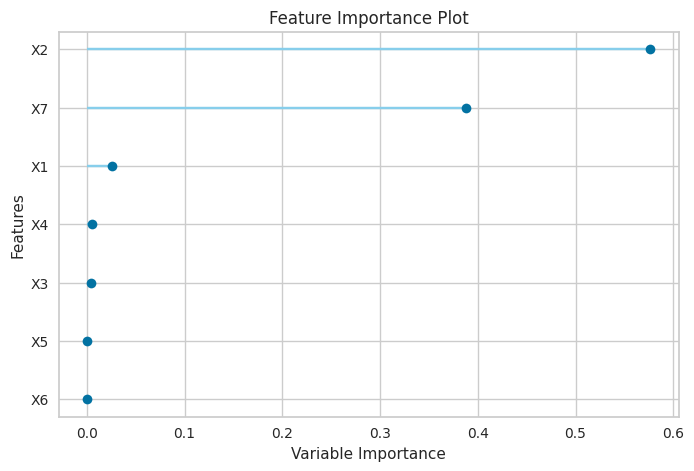

In [59]:
plot_model(final_model, plot='feature')

In [61]:
save_model(final_model, 'Models/regression_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                                              'X7'],
                                     transformer=KNNImputer(add_indicator=False,
                                                            copy=True,
                                                            keep_empty_features=False,
                                                            metric='nan_euclidean',
                                                            missing_values=nan,
                                                            n_neighbors=5,
                                                            weights='uniform'))),
                 ('categorical_imputer',
                  TransformerWrappe...
                                            criterion='friedman_mse', init=None,
   